In [2]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

In [3]:
import logging
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from network import GPCopulaNet
from strategy import EnhancedRiskParity, RiskParity
from utils import train_test_split, transform
from preprocessing import load_data

In [4]:
data_d, data_w, data_m = load_data('D'), load_data('W'), load_data('M')
lret_w = np.log(data_w/data_w.shift(1)).fillna(0.0)
df_tr, df_te = train_test_split(lret_w)
_, cdf_tr = transform(torch.Tensor(df_tr.values))

# include neural net and call trained parameters.
model = GPCopulaNet(input_dim=1, hidden_dim=15, embed_dim=6, num_layers=2,
                    num_assets=7, seq_length=24, pred_length=4, batch_size=1, rank_size=2)
model.load_state_dict(torch.load('/Users/mac/Desktop/PycharmProjects/TAADL/models/GPCopulaNet_mean.pt')['net_params'])
model.init_weight()

In [5]:
def tactical_allocation(w:pd.DataFrame, pred:pd.DataFrame, uncert:pd.DataFrame):
    f = 1 + np.tanh((pred/uncert)) ** 2 

    w_high, w_low = w.resample('M').last().copy() * (uncert < 0.05) * 1 * f, w.resample('M').last().copy() * (uncert >= 0.05) * 1
    w_high_tot = w_high.sum(axis=1).where(w_high.sum(axis=1) > 1, 1)
    w_high = w_high.div(w_high_tot.values.reshape(-1,1), axis=1)

    w_low_tot = 1 - w_high.sum(axis=1)
    w_low = w_low.div(w_low.sum(axis=1).values.reshape(-1,1)) * w_low_tot.values.reshape(-1,1)
    adj_w = w_low.fillna(0.0) + w_high.fillna(0.0)

    months = pd.unique(w.index.strftime('%Y-%m'))
    w_ = w.copy()
    for month in months:
        w_.loc[month] = adj_w.loc[month].copy().values
    return w_

In [6]:
# Vanilla Risk Parity
rp = RiskParity(data_d)
rp.run()
rp.performance()

perf = rp.equity_curve.copy()
w_rp = rp.allocation.copy()

[1.0030559566381259] 6
[1.011823845031254] 7
[1.022339963058895] 8
[1.004391636001489] 9
[1.0248399854833334] 10
[1.0446826177699267] 11
[1.072178975250675] 12
[1.0706020492215744] 13
[1.0737513869604953] 14
[1.084556364604599] 15
[1.0676247825986738] 16
[1.068085268585924] 17
[1.085581171969004] 18
[1.1038962852676604] 19
[1.1134030511920854] 20
[1.1316408346461857] 21
[1.1556386393924185] 22
[1.1509778423909105] 23
[1.1623297517021145] 24
[1.1684325624689598] 25
[1.169461233828318] 26
[1.1855717435856405] 27
[1.2024617516648215] 28
[1.1801130122019412] 29
[1.1859812224397894] 30
[1.2051631938872769] 31
[1.298113439526832] 32
[1.3650030986930783] 33
[1.3083724669150971] 34
[1.3113298143541816] 35
[1.3029701261513997] 36
[1.312638637880501] 37
[1.2824531266924935] 38
[1.3124404769618174] 39
[1.3273193702899648] 40
[1.2652211956491957] 41
[1.2408494392474378] 42
[1.1875497717891574] 43
[1.121351162668] 44
[0.9946910889274981] 45
[0.9880869623389118] 46
[1.0502823396704657] 47
[1.0141727

In [7]:
enh_rp = EnhancedRiskParity(model, data_d, data_w, cdf_tr)
enh_rp.run()
enh_rp.performance()

pred   = enh_rp.prediction_mean.copy().resample('M').last()
uncert = enh_rp.prediction_uncertainty.copy().resample('M').last()

[1.001007810918354] 6
[1.0099059109079922] 7
[1.0208991356129637] 8
[1.003178973811416] 9
[1.0264259446590147] 10
[1.051846204538217] 11
[1.1096622388010176] 12
[1.1041296084776286] 13
[1.109894202244565] 14
[1.1195597095668735] 15
[1.0816625996459694] 16
[1.0819177011317902] 17
[1.1022752001248617] 18
[1.1208807847198743] 19
[1.123720573747951] 20
[1.1397383492875264] 21
[1.1646796052121442] 22
[1.1595616097257535] 23
[1.1831475135364051] 24
[1.189040344525009] 25
[1.1973103126252305] 26
[1.2229848329550574] 27
[1.233146825994093] 28
[1.212206481247613] 29
[1.1953659376229422] 30
[1.212456911404647] 31
[1.30005376418448] 32
[1.349077394074646] 33
[1.3051418377823334] 34
[1.3108431469948802] 35
[1.2939822723593977] 36
[1.2924973056469944] 37
[1.2622989348073652] 38
[1.2919014776776052] 39
[1.2981501895575573] 40
[1.2451448183279672] 41
[1.2294018116739671] 42
[1.2032237566505597] 43
[1.1233701403865948] 44
[0.9106806844130746] 45
[0.8634365387942629] 46
[0.9123437933075687] 47
[0.88747

In [8]:
rp_taa = RiskParity(data_d)
rp_taa.allocation = tactical_allocation(w_rp, pred, uncert)
rp_taa.performance()

[1.0009481628321641] 6
[1.0101914219972292] 7
[1.019164498192385] 8
[1.002423670971521] 9
[1.0197611060871006] 10
[1.0386244124986668] 11
[1.0609148885517155] 12
[1.0596063938744305] 13
[1.0594576558397848] 14
[1.0696865546181482] 15
[1.0546683265361005] 16
[1.0525263363439876] 17
[1.069377942495099] 18
[1.0863632570980672] 19
[1.0965092809927575] 20
[1.1091423580413948] 21
[1.1313696406881113] 22
[1.1240733322863727] 23
[1.1308546619685664] 24
[1.1405081936489467] 25
[1.1411965342633323] 26
[1.14883042279647] 27
[1.1647429891777397] 28
[1.1430841339017463] 29
[1.1504683150767152] 30
[1.169157098109984] 31
[1.2685294409546497] 32
[1.33408118782298] 33
[1.2858764668317069] 34
[1.3087756098900634] 35
[1.3006832479854986] 36
[1.3098861630875929] 37
[1.2726411413237941] 38
[1.2907580768668043] 39
[1.3052073153717105] 40
[1.2517761326956114] 41
[1.2290544898063296] 42
[1.1684366451338244] 43
[1.103006949786965] 44
[0.9929312962010525] 45
[0.9934052078347735] 46
[1.0570953734227615] 47
[1.02

In [9]:
perf['kelly_RP'] = enh_rp.equity_curve
perf['taa_RP']   = rp_taa.equity_curve

(<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>)

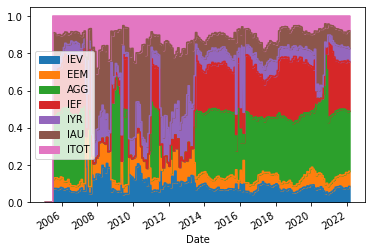

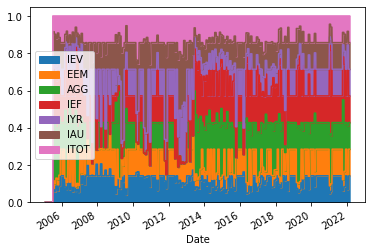

In [10]:
rp.allocation.plot.area(), enh_rp.allocation.plot.area()

In [11]:
lret_m = np.log(data_m/data_m.shift()).fillna(0.0)
lret_m.loc['2005-07':]

mae = (pred - lret_m.loc['2005-07':]).abs().rolling(5).mean()

<AxesSubplot:xlabel='Date'>

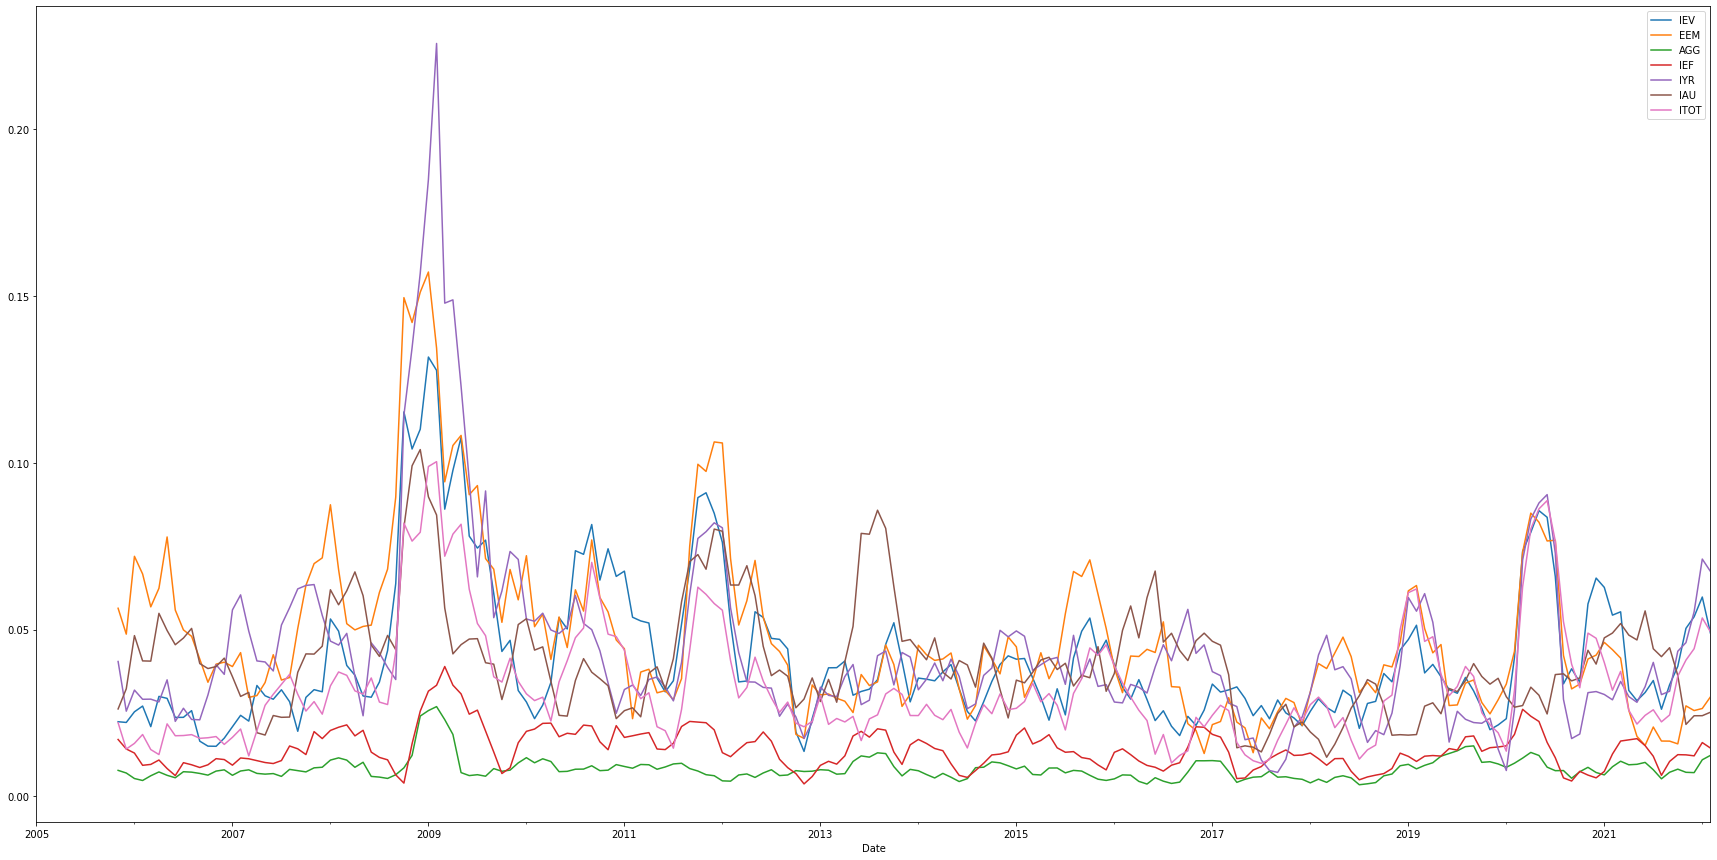

In [12]:
mae.plot(figsize=(30,15))

<AxesSubplot:xlabel='Date'>

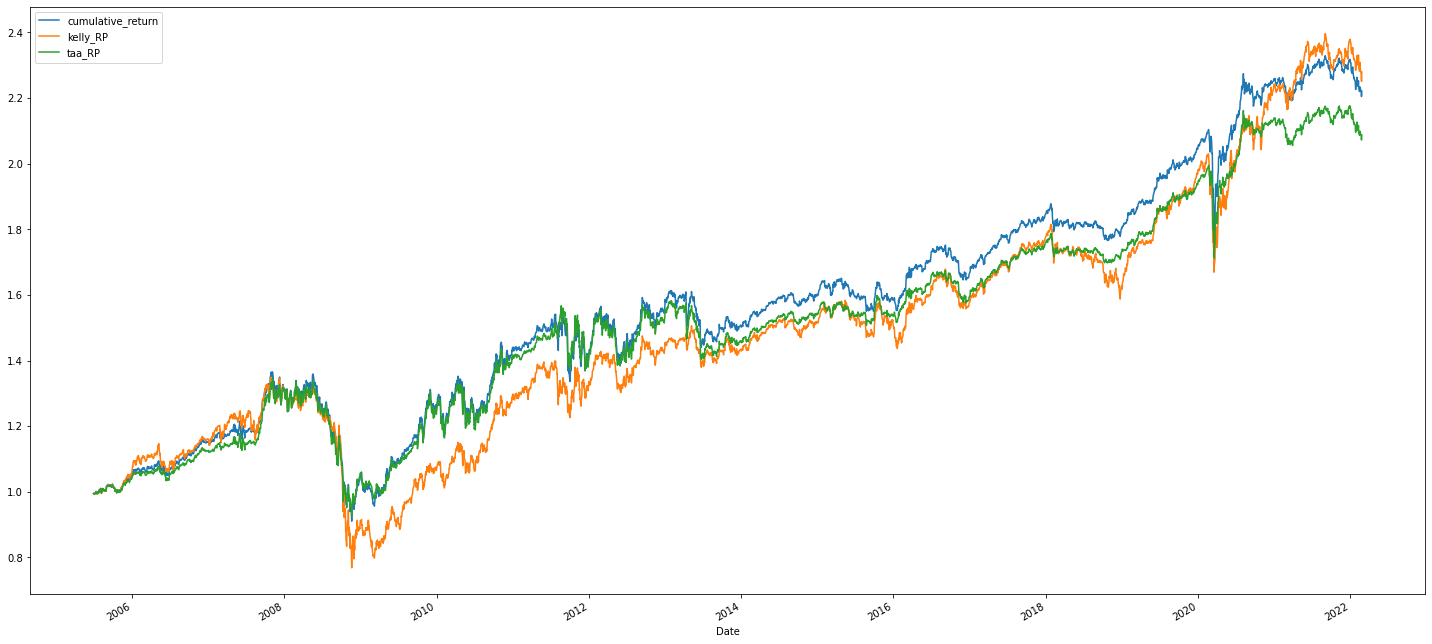

In [13]:
perf.plot(figsize=(25,12))

In [1]:
performance = perf.copy().dropna()


NameError: name 'perf' is not defined

In [103]:
np.log(performance/performance.shift(1))